# Data analysis

Analysis of the dataset introduced in [1]

[1] Willett, F.R., Kunz, E.M., Fan, C. et al. A high-performance speech neuroprosthesis. Nature 620, 1031–1036 (2023). https://doi.org/10.1038/s41586-023-06377-x

## Data Import

In [1]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text import Brain2TextDataset
from src.args.yaml_config import YamlConfig
import torch
from typing import Literal

In [2]:
def get_dataset(split: Literal['train', 'val', 'test'], preprocessing_mode: Literal[
        "competition_recommended",
        "seperate_zscoring",
        "only_tx_unnormalized",
        "only_tx_zscored",
        "only_spikepow_unnormalized",
        "only_spikepow_zscored",
    ]):
    config = B2TDatasetArgsModel()
    yaml_config = YamlConfig().config
    config.preprocessing = preprocessing_mode
    brain_data = Brain2TextDataset(
        config=config, yaml_config=yaml_config, split="train"
    ).brain_data_samples
    return torch.cat(brain_data, dim=0).flatten().numpy()

## Analysis

In [3]:
import numpy as np
from analysis.helpers import show_spike_hist, show_statistics

### Spike Power

Description by the dataset authors:

S x 1 vector containing a time series of spike power neural features for each sentence (S = number of sentences). 

Each entry is a T x F matrix of binned spike band power (20 ms bins), where T = number of time steps in the sentence and F = number of channels (256). 

Spike band power was defined as the mean of the squared voltages observed on the channel after high-pass filtering (250 Hz cutoff; units of microvolts squared). 

The data was denoised with a linear regression reference technique. 

The channels correspond to the arrays as follows (where 000 refers to the first column of spikePow and 255 refers to the last)

In [4]:
train_spike_pow_samples = get_dataset("train", "only_spikepow_unnormalized")
# val_spike_pow_samples = get_dataset("val", "only_spikepow_unnormalized")
test_spike_pow_samples = get_dataset("test", "only_spikepow_unnormalized")

Got tokenizer from file
Got tokenizer from file


Summary - train set
Min: 35.23589324951172, Max: 331745.0625
Mean: 1065.07666015625
Var: 1775620.2550101825


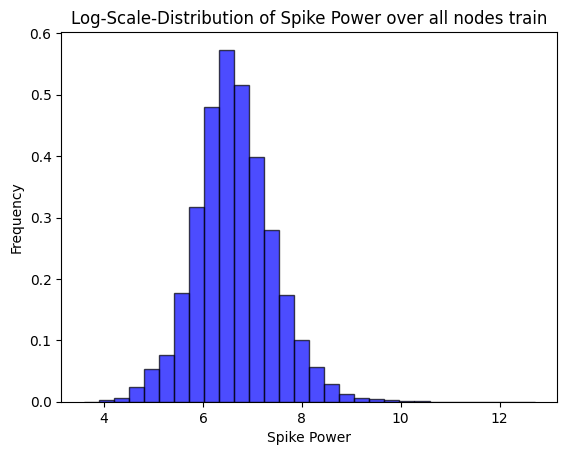

In [5]:
show_statistics(train_spike_pow_samples, "train")
show_spike_hist(train_spike_pow_samples, "train", log_scale=True)

In [6]:
# show_statistics(val_spike_pow_samples, "val")
# show_spike_hist(val_spike_pow_samples, "val")

Summary - test set
Min: 35.23589324951172, Max: 331745.0625
Mean: 1065.07666015625
Var: 1775620.2550101825


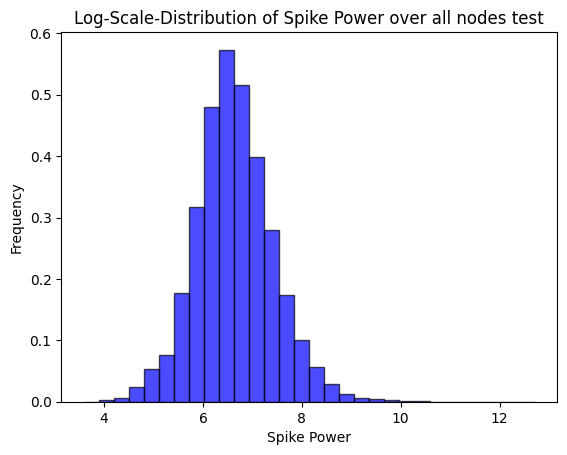

In [7]:
show_statistics(test_spike_pow_samples, "test")
show_spike_hist(test_spike_pow_samples, "test", log_scale=True)

### Spike count (tx1)

Description by dataset authors:

S x 1 vector containing a time series of threshold crossing neural features for each sentence (S = number of sentences). 

Each entry is a T x F matrix of binned threshold crossing counts (20 ms bins), where T = number of time steps in the sentence and F = number of channels (256). 

The data was denoised with a linear regression reference technique and a -3.5 x RMS threshold was used. 

The channels correspond to the arrays in the same way as spikePow described above. 

Note that threshold crossing counts describe the number of times the voltage recorded on an electrode crossed a threshold within a given time bin (essentially, this roughly counts the number of nearby action potentials observed on an elctrode in a given time bin).

In [8]:
train_spike_pow_samples = get_dataset("train", "only_tx_unnormalized")
# val_spike_pow_samples = get_dataset("val", "only_spikepow_unnormalized")
test_spike_pow_samples = get_dataset("test", "only_tx_unnormalized")

Got tokenizer from file
Got tokenizer from file


Summary - train set
Min: 0, Max: 29
Mean: 0.643225403523336
Var: 0.7563478067761558


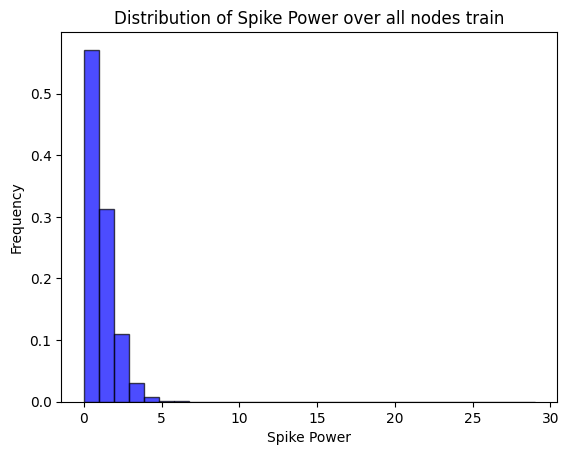

In [9]:
show_statistics(train_spike_pow_samples, "train")
show_spike_hist(train_spike_pow_samples, "train")

In [10]:
# show_statistics(val_spike_pow_samples, "val")
# show_spike_hist(val_spike_pow_samples, "val")

Summary - test set
Min: 0, Max: 29
Mean: 0.643225403523336
Var: 0.7563478067761558


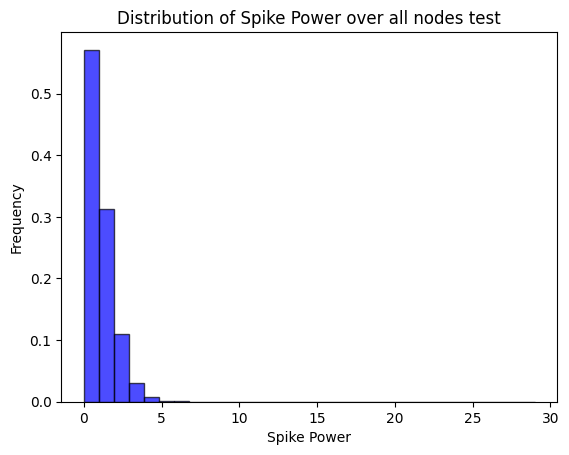

In [11]:
show_statistics(test_spike_pow_samples, "test")
show_spike_hist(test_spike_pow_samples, "test")